<a href="https://colab.research.google.com/github/KD1994/EIP-Sessions/blob/master/Week-4/Assignment-4B/Assignment_4B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils, plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.regularizers import l1, l2
from keras.optimizers import Adam, SGD
from keras.models import load_model, Model
from keras.datasets import cifar10
import warnings
import os
import cv2
from google.colab.patches import cv2_imshow

% matplotlib inline
warnings.filterwarnings("ignore")
np.random.seed(2017) 

Using TensorFlow backend.


# Load Data

In [2]:
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 11s 0us/step


# Data Exploration

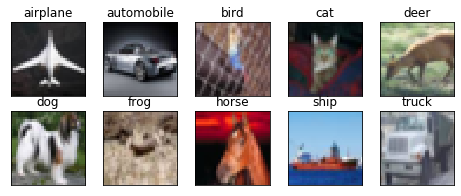

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

# Utility functions

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid(True)
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid(True)
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

# preprocess

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Resnet-18 Creation
Original ResNet-18 Architeecture, except first MaxPooling, as image is quite small.


In [0]:
def resnet_layer(inputs,
                 num_filters=64,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Convolution2D(num_filters,
                         kernel_size=kernel_size,
                         strides=strides,
                         padding=padding,
                         kernel_initializer='he_normal',
                         kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.

    Features maps sizes:
    stage 0: 56x56, 64
    stage 1: 28x28, 128
    stage 2: 14x14, 256
    stage 3: 7x7  , 512 

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 8 != 0:
        raise ValueError('depth should be 8n+2 (eg 18)')
    # Start model definition.
    num_filters = 64
    num_res_blocks = int((depth - 2) / 8)
    num_stack = 4
    use_maxpool = False

    # First Layer with 7x7 Kernel size and maxpooling with 3x3 with strides 2
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs, num_filters=64, kernel_size=7, strides=2, padding='same')
    if use_maxpool:
        x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x)
        num_stack = 3

    # Instantiate the stack of residual units
    for stack in range(num_stack):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    
    block_shape = K.int_shape(x)
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=(block_shape[1], block_shape[2]), strides=1)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
resnet18 = resnet(input_shape=(32, 32, 3), depth=18)

resnet18.compile(loss='categorical_crossentropy',
                 optimizer=Adam(0.003),
                 metrics=['accuracy'])
resnet18.summary()















Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 16, 64)   0           batch_normalization_1[0][0]      
______________________________________________________________________________

## Training

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
def scheduler(epoch, lr):
    return round(0.003 * 1/(1 + 0.319 * epoch), 10)

lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), verbose=1,
                               cooldown=0,
                               patience=3,
                               min_lr=0.0001)
                               # min_lr=0.5e-6)

datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
                            samplewise_center=False,  # set each sample mean to 0
                            featurewise_std_normalization=False,  # divide inputs by std of the dataset
                            samplewise_std_normalization=False,  # divide each input by its std
                            zca_whitening=False,  # apply ZCA whitening
                            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                            horizontal_flip=True,  # randomly flip images
                            vertical_flip=False,
                            preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))                                                          

# Save the best weights to model
op_file = os.path.join(os.getcwd(), 'best_weights.hdf5')
checkpoint = ModelCheckpoint(op_file, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')

# train the model
start = time.time()

model_info = resnet18.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                    samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                    validation_data = (test_features, test_labels), verbose=1, 
                                    callbacks=[checkpoint, lr_reducer])

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
390/390 [==============================] - 77s 196ms/step - loss: 2.8290 - acc: 0.3282 - val_loss: 2.6819 - val_acc: 0.2638

Epoch 00001: val_acc improved from -inf to 0.26380, saving model to /content/best_weights.hdf5
Epoch 2/50
390/390 [==============================] - 68s 176ms/step - loss: 1.9195 - acc: 0.4461 - val_loss: 1.9405 - val_acc: 0.4438

Epoch 00002: val_acc improved from 0.26380 to 0.44380, saving model to /content/best_weights.hdf5
Epoch 3/50
390/390 [==============================] - 68s 175ms/step - loss: 1.6883 - acc: 0.5063 - val_loss: 1.6572 - val_acc: 0.5069

Epoch 00003: val_acc improved from 0.44380 to 0.50690, saving model to /content/best_weights.hdf5
Epoch 4/50
390/390 [==============================] - 68s 175ms/step - loss: 1.5490 - acc: 0.5579 - val_loss: 1.7222 - val_acc: 0.5092

Epoch 00004: val_acc improved from 0.50690 to 0.50920, saving model t

## Plot

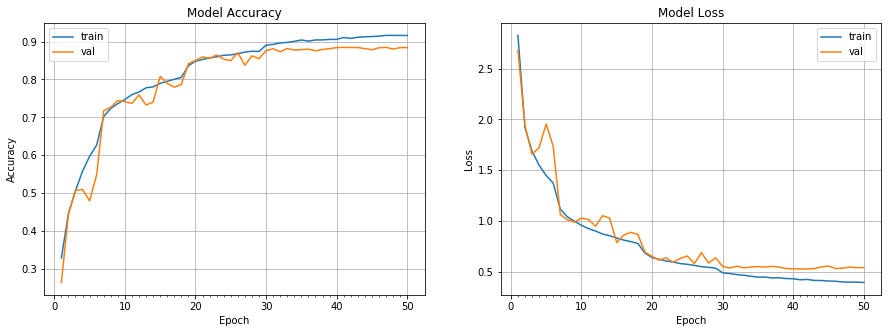

Accuracy on test data is: 88.48
CPU times: user 13.2 s, sys: 659 ms, total: 13.9 s
Wall time: 16.7 s


In [0]:
%%time
# plot model history
plot_model_history(model_info)
# compute test accuracy

# Load Saved Model
best_model = load_model('/content/best_weights.hdf5')
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, best_model))

# ResNet-18 Version-1
Given Example of ResNet-20 Architecture without change.

In [0]:
def resnet_layer(inputs,
                 num_filters=64,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Convolution2D(num_filters,
                         kernel_size=kernel_size,
                         strides=strides,
                         padding=padding,
                         kernel_initializer='he_normal',
                         kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.

    Features maps sizes:
    stage 0: 56x56, 64
    stage 1: 28x28, 128
    stage 2: 14x14, 256
    stage 3: 7x7  , 512 

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 8n+2 (eg 18)')
    # Start model definition.
    num_filters = 64
    num_res_blocks = int((depth - 2) / 9)
    num_stack = 4
    use_maxpool = False

    # First Layer with 7x7 Kernel size and maxpooling with 3x3 with strides 2
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs, num_filters=64)
    if use_maxpool:
        x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x)
        num_stack = 3

    # Instantiate the stack of residual units
    for stack in range(num_stack):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    
    block_shape = K.int_shape(x)
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=(block_shape[1], block_shape[2]), strides=1)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
resnet20 = resnet(input_shape=(32, 32, 3), depth=20)

resnet20.compile(loss='categorical_crossentropy',
                 optimizer=Adam(0.003),
                 metrics=['accuracy'])
resnet20.summary()















Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
______________________________________________________________________________

## Version-1 Training 

In [0]:
# def scheduler(epoch, lr):
#     return round(0.003 * 1/(1 + 0.319 * epoch), 10)

# lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), verbose=1,
                               cooldown=0,
                               patience=3,
                               min_lr=0.0001)
                               # min_lr=0.5e-6)

datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
                            samplewise_center=False,  # set each sample mean to 0
                            featurewise_std_normalization=False,  # divide inputs by std of the dataset
                            samplewise_std_normalization=False,  # divide each input by its std
                            zca_whitening=False,  # apply ZCA whitening
                            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                            horizontal_flip=True,  # randomly flip images
                            vertical_flip=False,
                            preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))                                                          

# Save the best weights to model
op_file = os.path.join(os.getcwd(), 'CIFAR_10_Resnet20_weights.h5')
checkpoint = ModelCheckpoint(op_file, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')

# train the model
start = time.time()

model_info = resnet20.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                    samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                    validation_data = (test_features, test_labels), verbose=1, 
                                    callbacks=[checkpoint, lr_reducer])

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
390/390 [==============================] - 78s 200ms/step - loss: 2.8402 - acc: 0.3119 - val_loss: 3.3676 - val_acc: 0.2439

Epoch 00001: val_acc improved from -inf to 0.24390, saving model to /content/CIFAR_10_Resnet20_weights.h5
Epoch 2/50
390/390 [==============================] - 71s 182ms/step - loss: 1.8970 - acc: 0.4612 - val_loss: 1.8926 - val_acc: 0.4673

Epoch 00002: val_acc improved from 0.24390 to 0.46730, saving model to /content/CIFAR_10_Resnet20_weights.h5
Epoch 3/50
390/390 [==============================] - 71s 183ms/step - loss: 1.6483 - acc: 0.5362 - val_loss: 1.5806 - val_acc: 0.5516

Epoch 00003: val_acc improved from 0.46730 to 0.55160, saving model to /content/CIFAR_10_Resnet20_weights.h5
Epoch 4/50
390/390 [==============================] - 71s 183ms/step - loss: 1.4865 - acc: 0.5887 - val_loss: 3.4302 - val_acc: 0.3981

Epoch 00004: val_acc did not improve

## Plot

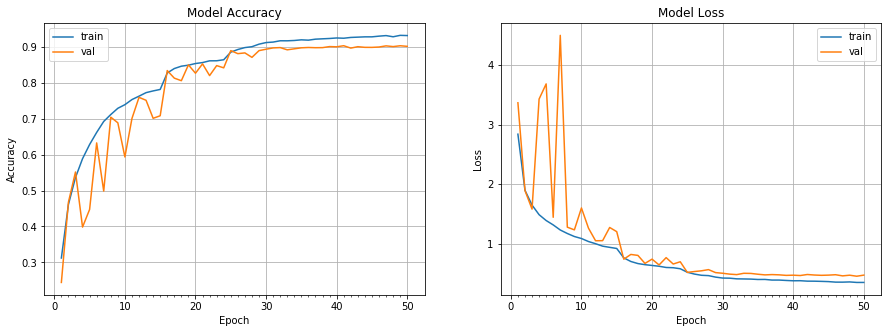

Accuracy on test data is: 90.33
CPU times: user 9.72 s, sys: 519 ms, total: 10.2 s
Wall time: 13.9 s


In [0]:
%%time
# plot model history
plot_model_history(model_info)
# compute test accuracy

# Load Saved Model
best_model = load_model('/content/CIFAR_10_Resnet20_weights.h5')
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, best_model))

# ResNet-18 Version-2
Update the Last stack of the Residual Block with strides=1 not 2, in order to receive the 8, 8, 512 at the last convolution layer.

In [0]:
def resnet_layer(inputs,
                 num_filters=64,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Convolution2D(num_filters,
                         kernel_size=kernel_size,
                         strides=strides,
                         padding=padding,
                         kernel_initializer='he_normal',
                         kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.

    Features maps sizes:
    stage 0: 56x56, 64
    stage 1: 28x28, 128
    stage 2: 14x14, 256
    stage 3: 7x7  , 512 

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 8n+2 (eg 18)')
    # Start model definition.
    num_filters = 64
    num_res_blocks = int((depth - 2) / 9)
    num_stack = 4
    use_maxpool = False

    # First Layer with 7x7 Kernel size and maxpooling with 3x3 with strides 2
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs, num_filters=64)
    if use_maxpool:
        x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x)
        num_stack = 3

    # Instantiate the stack of residual units
    for stack in range(num_stack):
        for res_block in range(num_res_blocks):
            strides = 1
            if 0 < stack < 3 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            if stack == 3 and res_block == 0:
                strides = 1

                y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
                y = resnet_layer(inputs=y,
                                num_filters=num_filters,
                                activation=None)
                if stack > 0 and res_block == 0:  # first layer but not first stack
                    # linear projection residual shortcut connection to match
                    # changed dims
                    x = resnet_layer(inputs=x,
                                    num_filters=num_filters,
                                    kernel_size=1,
                                    strides=strides,
                                    activation=None,
                                    batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    
    block_shape = K.int_shape(x)
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=(block_shape[1], block_shape[2]), strides=1)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
resnet20_v2 = resnet(input_shape=(32, 32, 3), depth=20)

resnet20_v2.compile(loss='categorical_crossentropy',
                 optimizer=Adam(0.003),
                 metrics=['accuracy'])
resnet20_v2.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, 32, 32, 64)   1792        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, 32, 32, 64)   256         conv2d_99[0][0]                  
__________________________________________________________________________________________________
activation_83 (Activation)      (None, 32, 32, 64)   0           batch_normalization_84[0][0]     
____________________________________________________________________________________________

## Version-2 Training 

In [0]:
# def scheduler(epoch, lr):
#     return round(0.003 * 1/(1 + 0.319 * epoch), 10)

# lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), verbose=1,
                               cooldown=0,
                               patience=3,
                               min_lr=0.0001)
                               # min_lr=0.5e-6)

datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
                            samplewise_center=False,  # set each sample mean to 0
                            featurewise_std_normalization=False,  # divide inputs by std of the dataset
                            samplewise_std_normalization=False,  # divide each input by its std
                            zca_whitening=False,  # apply ZCA whitening
                            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                            horizontal_flip=True,  # randomly flip images
                            vertical_flip=False,
                            preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))                                                          

# Save the best weights to model
op_file = os.path.join(os.getcwd(), 'CIFAR_10_Resnet20_weights.h5')
checkpoint = ModelCheckpoint(op_file, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')

# train the model
start = time.time()

model_info = resnet20_v2.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                       samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                       validation_data = (test_features, test_labels), verbose=1, 
                                       callbacks=[checkpoint, lr_reducer])

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

Epoch 1/50
390/390 [==============================] - 98s 252ms/step - loss: 2.9545 - acc: 0.3032 - val_loss: 2.2674 - val_acc: 0.3431

Epoch 00001: val_acc improved from -inf to 0.34310, saving model to /content/CIFAR_10_Resnet20_weights.h5
Epoch 2/50
390/390 [==============================] - 88s 226ms/step - loss: 1.8727 - acc: 0.4744 - val_loss: 2.0945 - val_acc: 0.4256

Epoch 00002: val_acc improved from 0.34310 to 0.42560, saving model to /content/CIFAR_10_Resnet20_weights.h5
Epoch 3/50
390/390 [==============================] - 88s 226ms/step - loss: 1.6021 - acc: 0.5562 - val_loss: 2.7243 - val_acc: 0.3359

Epoch 00003: val_acc did not improve from 0.42560
Epoch 4/50
390/390 [==============================] - 88s 226ms/step - loss: 1.4424 - acc: 0.6061 - val_loss: 1.7632 - val_acc: 0.5195

Epoch 00004: val_acc improved from 0.42560 to 0.51950, saving model to /content/CIFAR_10_Resnet20_weights.h5
Epoch 5/50
390/390 [==============================] - 88s 226ms/step - loss: 1.339

## Plot

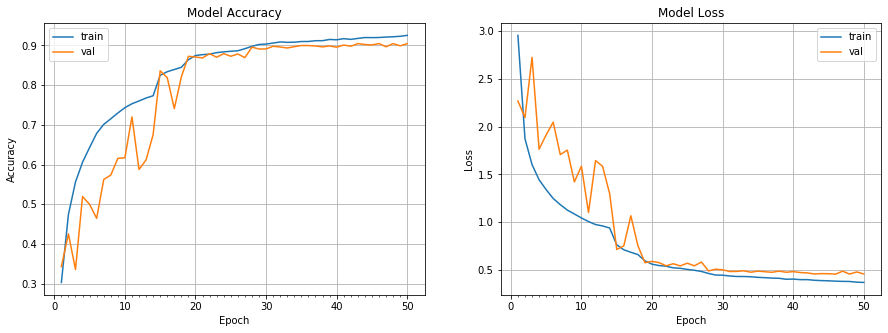

Accuracy on test data is: 90.47
CPU times: user 19.2 s, sys: 580 ms, total: 19.8 s
Wall time: 24.8 s


In [0]:
%%time
# plot model history
plot_model_history(model_info)
# compute test accuracy

# Load Saved Model
best_model = load_model('/content/CIFAR_10_Resnet20_weights.h5')
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, best_model))

# GRADCAM

In [0]:
best_model = load_model('/content/CIFAR_10_ResNet20_v2.h5')
print('model loaded!')

# Process for GradCam

In [0]:
def process_image(image):
    # 1. We get the predictions for the image
    # 2. We take the topmost class index
    # 3. Take output from the final convolutional layer
    # image = image.astype('uint8')
    x = np.expand_dims(image, axis=0)
    preds = best_model.predict(x)
    idx = np.argmax(preds[0])
    cls = class_names[idx.item()]
    class_output = best_model.output[:, idx]
    last_conv_layer = best_model.get_layer("conv2d_121")

    # 1. Compute the gradient of the class output value with respect to the feature map
    # 2. Pool the gradients over all the axies leaving out the channel dimension
    # 3. Weigh the output feature map with the computed gradient values
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([best_model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # 1. Average the weighted feature map along the channel dimension resulting in a heat map of size 8x8 
    # 2. Normalize the heat map to make the values between 0 and 1
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = heatmap/255

    superimposed_img = 0.5*(image) + 0.5*heatmap

    return superimposed_img, cls

## Sample

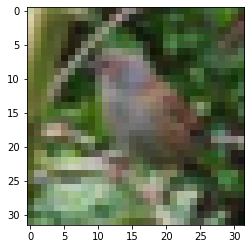

In [0]:
plt.imshow(np.copy(test_features[65]))

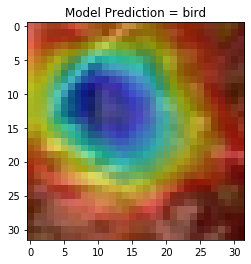

In [29]:
img, prediction = process_image(np.copy(test_features[65]))
plt.title("Model Prediction = "+ prediction)
plt.imshow(img)

## Plot Heatmap

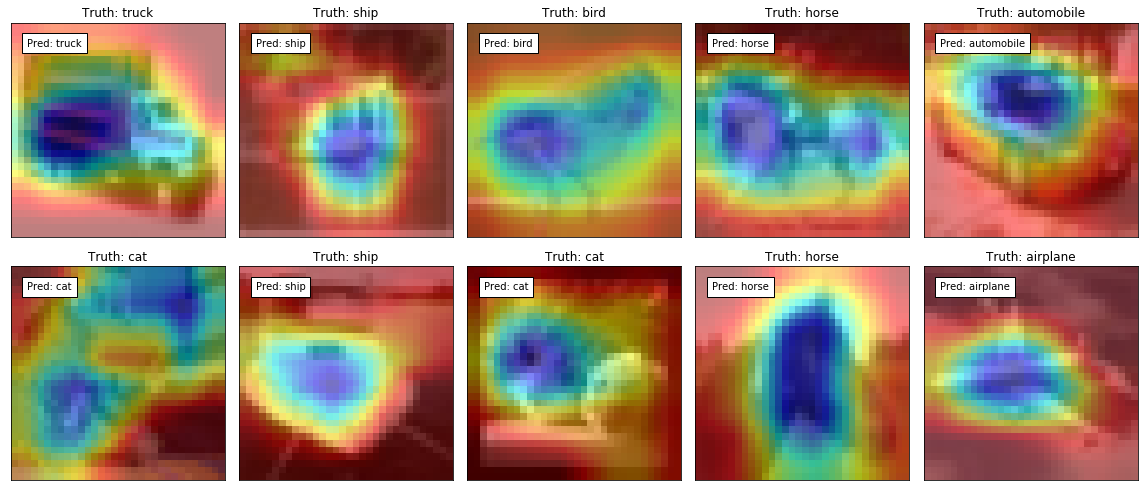

In [30]:
randord = np.random.permutation(test_features.shape[0])

fig = plt.figure(figsize=(16, 7))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    im = test_features[randord[i]]
    # Call Process_image to get the heatmap
    img, pred_class = process_image(im)
    ax.set_title('Truth: '+ class_names[np.argmax(test_labels[randord[i]]).item()])
    ax.text(2, 3, 'Pred: ' + pred_class, bbox={'facecolor': 'white', 'pad': 5})
    plt.imshow(img)

plt.tight_layout()
plt.show()